In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import shap

In [3]:
df = pd.read_csv(r"C:\Users\91930\Downloads\archive (1)\fraudTrain.csv")

In [4]:
display(df.head())

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

None

In [6]:
display(df.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

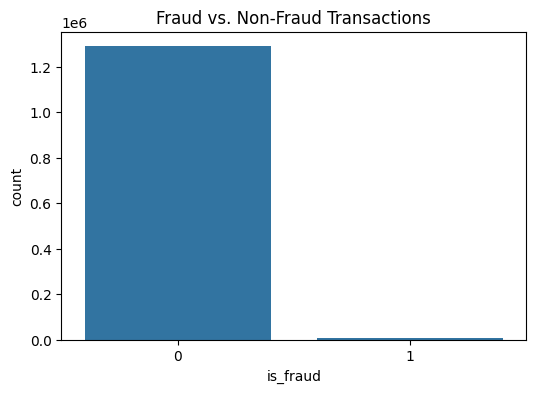

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['is_fraud'])
plt.title("Fraud vs. Non-Fraud Transactions")
plt.show()


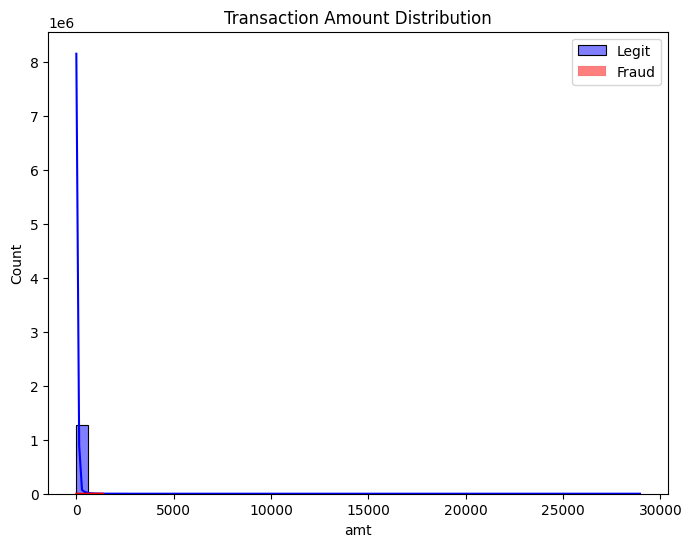

In [8]:
plt.figure(figsize=(8,6))
sns.histplot(df[df['is_fraud'] == 0]['amt'], bins=50, color='blue', label='Legit', kde=True)
sns.histplot(df[df['is_fraud'] == 1]['amt'], bins=50, color='red', label='Fraud', kde=True)
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()

In [9]:
label_enc = LabelEncoder()
df['category'] = label_enc.fit_transform(df['category'])
df['gender'] = label_enc.fit_transform(df['gender'])
df['state'] = label_enc.fit_transform(df['state'])
df['job'] = label_enc.fit_transform(df['job'])

In [10]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['weekday'] = df['trans_date_trans_time'].dt.weekday
df.drop(['dob', 'trans_date_trans_time'], axis=1, inplace=True)

In [11]:
features = ['category', 'amt', 'gender', 'city_pop', 'job', 'age', 'lat', 'long', 'merch_lat', 'merch_long', 'transaction_hour', 'weekday']
X = df[features]
y = df['is_fraud']

In [12]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
param_dist = {
    'n_estimators': [50, 100],  # Reduced from 200 to speed up
    'max_depth': [5, 10],  # Limited depth for faster training
    'min_samples_split': [2, 5],  # Reduced options
    'min_samples_leaf': [1, 2]  # Fewer variations
}

In [16]:
clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=2, verbose=1, n_jobs=-1)  # Reduced n_iter and cv for speed
random_search.fit(X_train, y_train)
clf_best = random_search.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits


In [17]:
y_pred = clf_best.predict(X_test)
y_prob = clf_best.predict_proba(X_test)[:, 1]

In [18]:
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94    257186
           1       0.97      0.91      0.94    258482

    accuracy                           0.94    515668
   macro avg       0.94      0.94      0.94    515668
weighted avg       0.94      0.94      0.94    515668

ROC AUC Score: 0.9884454986516287


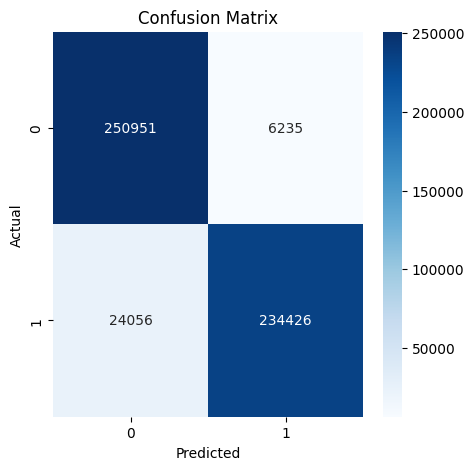

In [19]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<Figure size 640x480 with 0 Axes>

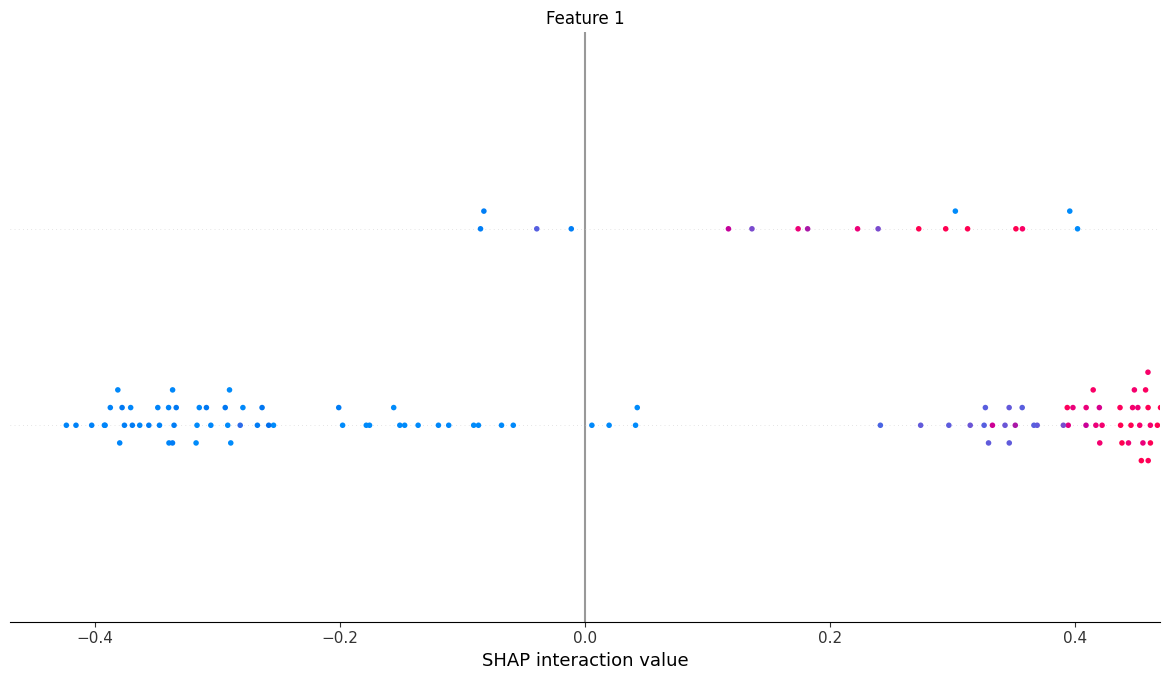

In [20]:
explainer = shap.Explainer(clf_best, X_train)
shap_values = explainer(X_test[:100])
shap.summary_plot(shap_values, X_test[:100])

In [21]:
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

False Positives: 6235
False Negatives: 24056
